<a href="https://colab.research.google.com/github/Vendredi218/deep-learning-mastery/blob/main/chapter_linear-regression/3.1linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 59.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


# Linear Regression


In [ ]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

## Basics



### Model
:label:`subsec_linear_model`



$$\hat{y} = w_1  x_1 + \cdots + w_d  x_d + b.$$

Collecting all features into a vector $\mathbf{x} \in \mathbb{R}^d$
and all weights into a vector $\mathbf{w} \in \mathbb{R}^d$,
we can express our model compactly via the dot product
between $\mathbf{w}$ and $\mathbf{x}$:

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$


 $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.
For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix--vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$


where **broadcasting** is applied during the summation.
*Given features of a training dataset $\mathbf{X}$
and corresponding (known) labels $\mathbf{y}$,
the goal of linear regression is to find
the weight vector $\mathbf{w}$ and the bias term $b$
such that, given features of a new data example
sampled from the same distribution as $\mathbf{X}$,
the new example's label will (in expectation)
be predicted with the smallest error.*


### Loss Function

*Loss functions* quantify the distance
between the *real* and *predicted* values of the target.
The loss will usually be a nonnegative number
where smaller values are better
and perfect predictions incur a loss of 0.
For regression problems, the most common loss function is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the *squared error* is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$


To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set:

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we seek parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

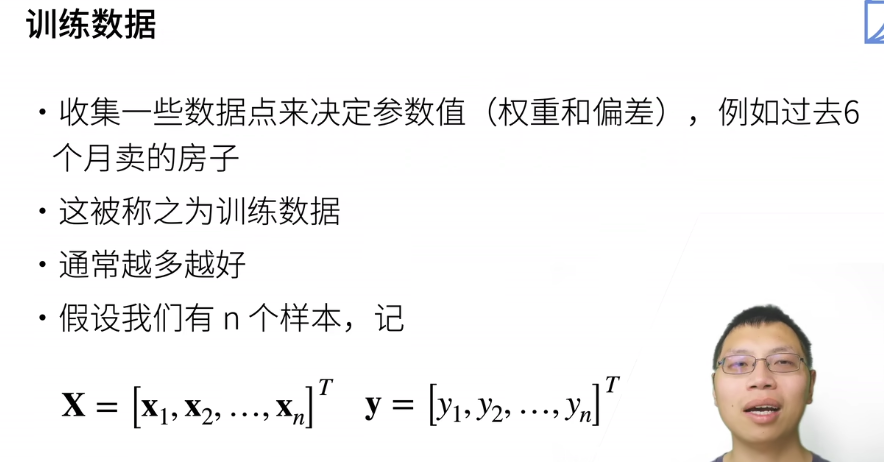

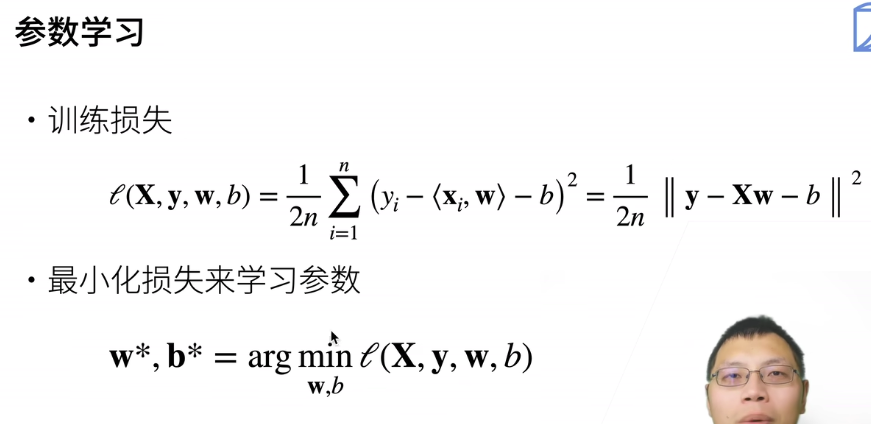

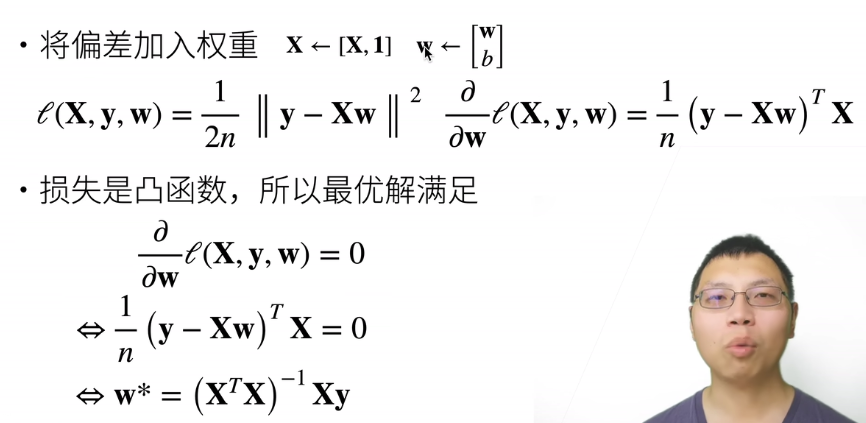


### Analytic Solution

Unlike most of the models that we will cover,
linear regression presents us with
a surprisingly easy optimization problem.
In particular, we can find the optimal parameters
(as assessed on the training data)
analytically by applying a simple formula as follows.
First, we can subsume the bias $b$ into the parameter $\mathbf{w}$
by appending a column to the design matrix consisting of all 1s.
Then our prediction problem is to minimize $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$.
As long as the design matrix $\mathbf{X}$ has full rank
(no feature is linearly dependent on the others),
then there will be just one critical point on the loss surface
and it corresponds to the minimum of the loss over the entire domain.
Taking the derivative of the loss with respect to $\mathbf{w}$
and setting it equal to zero yields:

$$\begin{aligned}
    \partial_{\mathbf{w}} \|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2 =
    2 \mathbf{X}^\top (\mathbf{X} \mathbf{w} - \mathbf{y}) = 0
    \textrm{ and hence }
    \mathbf{X}^\top \mathbf{y} = \mathbf{X}^\top \mathbf{X} \mathbf{w}.
\end{aligned}$$

Solving for $\mathbf{w}$ provides us with the optimal solution
for the optimization problem.
Note that this solution

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}$$

will only be unique
when the matrix $\mathbf X^\top \mathbf X$ is invertible,
i.e., when the columns of the design matrix
are linearly independent




### Minibatch Stochastic Gradient Descent

**iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function.
This algorithm is called *gradient descent*.**

The most naive application of gradient descent
consists of taking the derivative of the loss function,
which is an average of the losses computed
on every single example in the dataset.
In practice, this can be extremely slow:
we must pass over the entire dataset before making a single update,
even if the update steps might be very powerful

The other extreme is to consider only a single example at a time and to take
update steps based on one observation at a time.
The resulting algorithm, *stochastic gradient descent* (SGD)
can be an effective strategy :cite:`Bottou.2010`, even for large datasets.
*Unfortunately, SGD has drawbacks, both computational and statistical.
One problem arises from the fact that processors are a lot faster
multiplying and adding numbers than they are
at moving data from main memory to processor cache.*

**The solution** to both problems is to pick an intermediate strategy:
rather than taking a full batch or only a single sample at a time,
we take a *minibatch* of observations
The specific choice of the size of the said minibatch depends on many factors,
such as the **amount of memory, the number of accelerators,
the choice of layers, and the total dataset size.
Despite all that, a number between 32 and 256,
preferably a multiple of a large power of $2$, is a good start.**
This leads us to *minibatch stochastic gradient descent*.

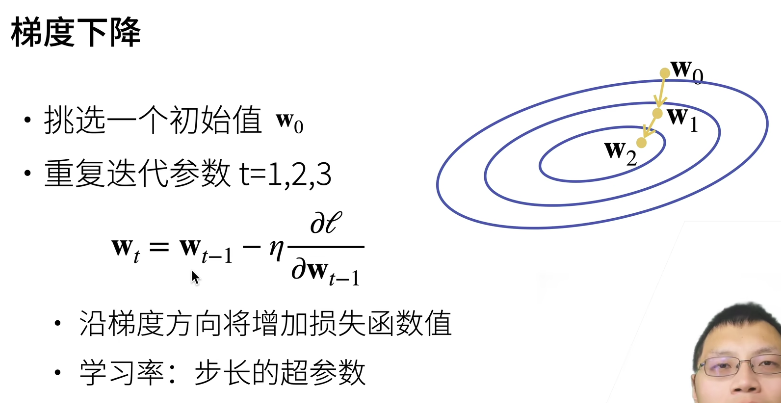

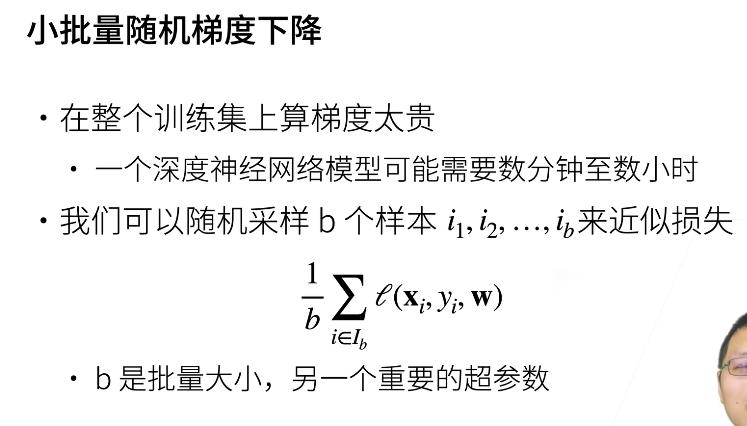

- 太贵因为：全部求导的话所有样本都要算一遍
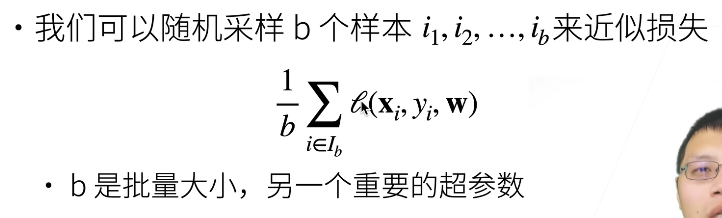




In summary, minibatch SGD proceeds as follows:
(i) initialize the values of the model parameters, typically at random;
(ii) iteratively sample random minibatches from the data,
updating the parameters in the direction of the negative gradient.
For quadratic losses and affine transformations,
this has a closed-form expansion:

$$\begin{aligned} \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) &&  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$



In [ ]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

We can now (**visualize the normal distributions**).


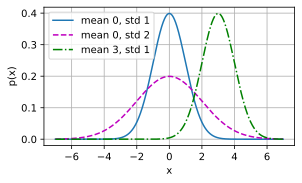

In [ ]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

Note that changing the mean corresponds
to a shift along the $x$-axis,
and increasing the variance
spreads the distribution out,
lowering its peak.

One way to motivate linear regression with squared loss
is to assume that observations arise from noisy measurements,
where the noise $\epsilon$ follows the normal distribution
$\mathcal{N}(0, \sigma^2)$:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Thus, we can now write out the *likelihood*
of seeing a particular $y$ for a given $\mathbf{x}$ via

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

As such, the likelihood factorizes.
According to *the principle of maximum likelihood*,
the best values of parameters $\mathbf{w}$ and $b$ are those
that maximize the *likelihood* of the entire dataset:

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$$

The equality follows since all pairs $(\mathbf{x}^{(i)}, y^{(i)})$
were drawn independently of each other.
Estimators chosen according to the principle of maximum likelihood
are called *maximum likelihood estimators*.
While, maximizing the product of many exponential functions,
might look difficult,
we can simplify things significantly, without changing the objective,
by maximizing the logarithm of the likelihood instead.
For historical reasons, optimizations are more often expressed
as minimization rather than maximization.
So, without changing anything,
we can *minimize* the *negative log-likelihood*,
which we can express as follows:

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

If we assume that $\sigma$ is fixed,
we can ignore the first term,
because it does not depend on $\mathbf{w}$ or $b$.
The second term is identical
to the squared error loss introduced earlier,
except for the multiplicative constant $\frac{1}{\sigma^2}$.
Fortunately, the solution does not depend on $\sigma$ either.
It follows that minimizing the mean squared error
is equivalent to the maximum likelihood estimation
of a linear model under the assumption of additive Gaussian noise.


[Discussions](https://discuss.d2l.ai/t/258)
